In [2]:
# imports
import pandas as pd
import pickle

from openai.embeddings_utils import (
    get_embedding,
    distances_from_embeddings,
    tsne_components_from_embeddings,
    chart_from_components,
    indices_of_nearest_neighbors_from_distances,
)

# constants
EMBEDDING_MODEL = "text-embedding-ada-002"

In [3]:
import os
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

In [4]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, model) -> embedding, saved as a pickle file

# set path to embedding cache
embedding_cache_path = "data/recommendations_embeddings_cache.pkl"

# load the cache if it exists, and save a copy to disk
try:
    embedding_cache = pd.read_pickle(embedding_cache_path)
except FileNotFoundError:
    embedding_cache = {}
with open(embedding_cache_path, "wb") as embedding_cache_file:
    pickle.dump(embedding_cache, embedding_cache_file)

# define a function to retrieve embeddings from the cache if present, and otherwise request via the API
def embedding_from_string(
    string: str,
    model: str = EMBEDDING_MODEL,
    embedding_cache=embedding_cache
) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, model) not in embedding_cache.keys():
        embedding_cache[(string, model)] = get_embedding(string, model)
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, model)]

In [5]:
# Ausprobieren:
# example_embedding = embedding_from_string("Lehrer")
# example_embedding

Lese die Liste der Ausbildungsberufe ein. Zunächst definieren wir eine Funktion um die Berufsbezeichnungen etwas aufzuräumen:

In [6]:
import re

clean_re = re.compile(r"""
    (.*?)\s*
    (?:\(.*\))?\s*
    (?:\[.*\])?$""", re.VERBOSE)

def cleanup_occupation(name: str) -> str:
    # Klammern am Ende entfernen
    m = clean_re.match(name)
    clean = m.group(1)

    # Jetzt haben wir etwas wie:
    # Ausbaufacharbeiter/Ausbaufacharbeiterin - Schwerpunkte Estricharbeiten, Fliesen-, Platten- und Mosaikarbeiten, Stukkateurarbeiten, Trockenbauarbeiten, Wärme-, Kälte- und Schallschutzarbeiten, Zimmerarbeiten
    # Entferne alles nach " - ":
    pos = clean.find(' - ')
    if pos >= 0:
        clean = clean[:pos]

    # Nur männliche Form nehmen
    pos = clean.find('/')
    if pos >= 0:
        clean = clean[:pos]

    return clean    

cleanup_occupation("Anlagenmechaniker für Sanitär-, Heizungs- und Klimatechnik/Anlagenmechanikerin für Sanitär-, Heizungs- und Klimatechnik (Hw, IH)")

'Anlagenmechaniker für Sanitär-, Heizungs- und Klimatechnik'

Wir lesen die Liste mit Pandas ein, säubern die Bezeichnungen, und entfernen Duplikate (welche z.B. entstanden weil wir Spezialisierungen rausgelöscht haben).

In [7]:
import pandas as pd

df = pd.read_csv('data/apprenticeships_A-Z.csv', delimiter=';', names=['Beruf', 'URL'])
df['Beruf'] = df['Beruf'].map(cleanup_occupation)
df = df.drop_duplicates(subset=['Beruf'])
df

Beruf  \
0                                   Änderungsschneider   
1    Anlagenmechaniker für Sanitär-, Heizungs- und ...   
2                                    Anlagenmechaniker   
3                                         Asphaltbauer   
4                              Aufbereitungsmechaniker   
..                                                 ...   
482                                Industriemechaniker   
483                           Informationselektroniker   
484                            Investmentfondskaufmann   
485                                Isolierfacharbeiter   
486                             IT-System-Elektroniker   

                                                   URL  
0    http://www.bibb.de/dienst/berufesuche/de/index...  
1    http://www.bibb.de/dienst/berufesuche/de/index...  
2    http://www.bibb.de/dienst/berufesuche/de/index...  
3    http://www.bibb.de/dienst/berufesuche/de/index...  
4    http://www.bibb.de/dienst/berufesuche/de/index...  
..                                                 ...  
482  http://www.bibb.de/dienst/berufesuche/de/index...  
483  http://www.bibb.de/dienst/berufesuche/de/index...  
484  http://www.bibb.de/dienst/berufesuche/de/index...  
485  http://www.bibb.de/dienst/berufesuche/de/index...  
486  http://www.bibb.de/dienst/berufesuche/de/index...  

[329 rows x 2 columns]

Wir holen die erste Spalte, und berechnen die "embeddings":

In [8]:
strings = list(df['Beruf'])
# strings = ["Lehrer", "Gärtner", "Automechaniker", "Maler", "Bäcker"]
strings[:5]

['Änderungsschneider',
 'Anlagenmechaniker für Sanitär-, Heizungs- und Klimatechnik',
 'Anlagenmechaniker',
 'Asphaltbauer',
 'Aufbereitungsmechaniker']

In [9]:
# Achtung, beim ersten mal kann das ein bisschen dauern und verbraucht GPT quota
embeddings = [embedding_from_string(s) for s in strings]

from IPython.lib.pretty import pprint
pprint(embeddings, max_seq_length=4)

[[-0.011428039520978928,
  0.006000214256346226,
  0.021027065813541412,
  -0.0076186927035450935,
  ...],
 [0.005802764557301998,
  0.003476517740637064,
  0.002711812499910593,
  -0.02999701537191868,
  ...],
 [-0.010611000470817089,
  -0.010322134010493755,
  0.006338997278362513,
  -0.014866954647004604,
  ...],
 [-0.01402454636991024,
  0.0015758965164422989,
  -0.0030025956220924854,
  -0.02619090862572193,
  ...],
 ...]


In [11]:
pprint(strings, max_seq_length=4)

['Änderungsschneider',
 'Anlagenmechaniker für Sanitär-, Heizungs- und Klimatechnik',
 'Anlagenmechaniker',
 'Asphaltbauer',
 ...]


Jetzt definieren wir unsere Suchfunktion. Wir rufen die Einbettung für unseren Suchstring ab, dann berechnen wir die Entfernung zu allen anderen Einbettungen, und schließlich ordnen wir die Entfernungen. Die verwendeten Funktionen sind alle bequemerweise teil von `openai.embeddings_utils`.

In [10]:
def get_closest(query_string, max_results=3):
    query_embedding = embedding_from_string(query_string)
    distances = distances_from_embeddings(query_embedding, embeddings, distance_metric="cosine")
    indices = indices_of_nearest_neighbors_from_distances(distances)
    return [(strings[i], distances[i]) for i in indices[:max_results]]
    
list(get_closest("Schneider"))

[('Änderungsschneider', 0.1136942661394642),
 ('Kürschner', 0.1164320099425129),
 ('Zimmerer', 0.1294014503566998)]

Probieren wir es mal für eine Reihe Berufsbezeichnungen aus, die ChatGPT ausgespuckt hat. Für die meisten findet es ein gutes Ergebnis. Man beachte, dass unsere Liste nur Ausbildungsberufe beeinhaltet.

In [25]:
occupations = ['Optiker',
 'Fotograf',
 'Optomechaniker',
 'Physiker',
 'Optoelektroniker',
 'Luft- und Raumfahrttechniker',
 'Opto-Elektronik-Designer']

for c in occupations:
    print(f"Search string: {c}")
    for name, dist in get_closest(c):
        print(f"Result: {name} (distance: {dist:0.3f})")
    print()
        

Search string: Optiker
Result: Augenoptiker (distance: 0.043)
Result: Feinoptiker (distance: 0.070)
Result: Verfahrensmechaniker für Brillenoptik (distance: 0.110)

Search string: Fotograf
Result: Fotograf (distance: 0.000)
Result: Fotomedienfachmann (distance: 0.139)
Result: Florist (distance: 0.163)

Search string: Optomechaniker
Result: Mechatroniker (distance: 0.082)
Result: Verfahrensmechaniker für Brillenoptik (distance: 0.090)
Result: Feinwerkmechaniker (distance: 0.095)

Search string: Physiker
Result: Physiklaborant (distance: 0.081)
Result: Geomatiker (distance: 0.096)
Result: Mechatroniker (distance: 0.109)

Search string: Optoelektroniker
Result: Elektroniker (distance: 0.076)
Result: Industrieelektriker (distance: 0.105)
Result: Elektroniker für Betriebstechnik (distance: 0.108)

Search string: Luft- und Raumfahrttechniker
Result: Fluggerätelektroniker (distance: 0.089)
Result: Fluggerätmechaniker (distance: 0.096)
Result: Luftverkehrskaufmann (distance: 0.105)

Search str

Man könnte das jetzt einfach benutzen, um zu den beliebigen Berufsbezeichnungen die "offiziellen" Berufsbezeichnungen a la KldB zu finden, und darüber die URL bei BIBB. Dann kann man daraus Links generieren:

In [27]:
from IPython.display import display, HTML

job_to_url = dict(zip(df['Beruf'], df['URL']))

def make_bibb_link(occupation: str):
    for kldb, dist in get_closest(occupation, max_results=1):
        url = job_to_url[kldb]
    return f'<a href="{url}" title="{kldb}">{occupation}</a>'

output = "<ul>" + "\n".join("<li>" + make_bibb_link(o) + "</li>" for o in occupations) + "</ul>"
display(HTML(output))
#print(output)

## Bonus: Visualisierung


In [13]:

beruf_kategorie = {
    "Asphaltbauer": "Bau",
    "Augenoptiker": "Medizin",
    "Bankkaufmann": "Handel",
    "Bauzeichner": "Bau",
    "Bodenleger": "Bau",
    "Buchhändler": "Handel",
    "Dachdecker": "Bau",
    "Drogist": "Medizin",
    "Fassadenmonteur": "Bau",
    "Geräustbauer": "Bau",
    "Hochbaufacharbeiter": "Bau",
    "Industrieelektriker": "Bau",
    "Isolierfacharbeiter": "Bau",
    "Kaufmann im Einzelhandel": "Handel",
    "Medizinischer Fachangestellter": "Medizin",
    "Musikfachhändler": "Handel",
    "Pharmakant": "Medizin",
    "Straßenbauer": "Bau",
    "Tourismuskaufmann": "Handel",
    "Verkäufer": "Handel",
    "Zahnmedizinischer Fachangestellter": "Medizin",
    "Zahntechniker": "Medizin",
    "Polier": "Bau",
    "Konditor": "Handel",
    "Apothekerin": "Medizin",
    "Arzthelferin": "Medizin",
    "Verkäufer": "Handel",
    "Zahnarzthelferin": "Medizin",
    "Physiotherapeut": "Medizin",
    "Kranfahrerin": "Bau",
    "Kaufmännischer Angestellter": "Handel"
}

jobs = beruf_kategorie.keys()
labels = beruf_kategorie.values()
embeddings = [embedding_from_string(s) for s in jobs]

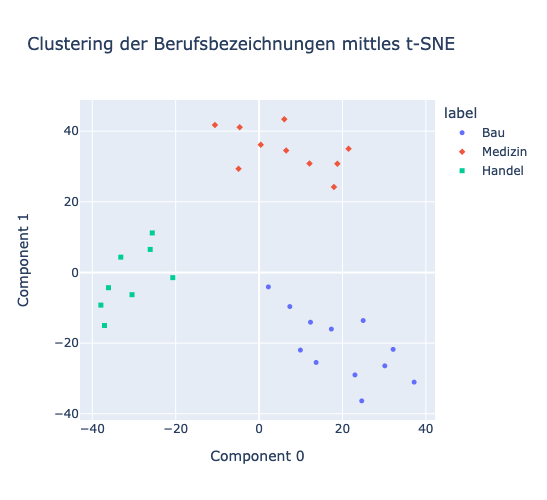

In [14]:
# compress the 2048-dimensional embeddings into 2 dimensions using t-SNE
# Note this does NOT look at the labels!
tsne_components = tsne_components_from_embeddings(embeddings, perplexity=5)

chart_from_components(
    components=tsne_components,
    labels=labels,
    strings=jobs,
    width=600,
    height=500,
    title="Clustering der Berufsbezeichnungen mittles t-SNE",
)
